In [2]:
import os
import sys
import platform
import numpy as np
import tensorflow as tf
import tensorflow.keras
import h5py
import numpy as np
import pandas as pd

In [1]:
# Functions string, add_dtype_name, recusive_dict are from : 
# https://github.com/wondonghyeon/face-classification/blob/master/mat73_to_pickle.py#L12-L104

In [6]:
dtypes = {}

In [7]:
def string(seq):
    """Convert a sequence of integers into a single string.
    """
    return ''.join([chr(a[0]) for a in seq])

In [8]:
def add_dtype_name(f, name):
    """Keep track of all dtypes and names in the HDF5 file using it.
    """
    global dtypes
    dtype = f.dtype         
    if dtype.name not in dtypes:
        dtypes[dtype.name] = [name]
    else:
        dtypes[dtype.name] = set([name])
    return

In [9]:
def recursive_dict(f, root=None, name='root'):
    """This function recursively navigates the HDF5 structure from
    node 'f' and tries to unpack the data structure by guessing their
    content from dtype, shape etc.. It returns a dictionary of
    strings, arrays and some leftovers. 'root' is the root node of the
    HDF5 structure, i.e. what h5py.File() returns.

    Note that this function works well on the Matlab7.3 datasets on
    which it was tested, but in general it might be wrong and it might
    crash. The motivation is that it has to guess the content of
    substructures so it might fail. One source of headache seems to be
    Matlab7.3 format that represents strings as array of 'uint16' so
    not using the string datatype. For this reason it is not possible
    to discriminate strings from arrays of integers without using
    heuristics.
    """
    if root is None: root = f
    if hasattr(f, 'keys'):
        a = dict(f)
        if u'#refs#' in a.keys(): # we don't want to keep this
            del(a[u'#refs#'])
        for k in a.keys():
            # print k
            a[k] = recursive_dict(f[k], root, name=name+'->'+k)
        return a
    elif hasattr(f, 'shape'):
        if f.dtype.name not in ['object', 'uint16']: # this is a numpy array
            # Check shape to assess whether it can fit in memory
            # or not. If not recast to a smaller dtype!
            add_dtype_name(f, name)
            dtype = f.dtype
            if (np.prod(f.shape)*f.dtype.itemsize) > 2e9:
                print("WARNING: The array", name, "requires > 2Gb")
                if f.dtype.char=='d':
                    print("\t Recasting", dtype, "to float32")
                    dtype = np.float32
                else:
                    raise MemoryError
            return np.array(f, dtype=dtype).squeeze()
        elif f.dtype.name in ['uint16']: # this may be a string for Matlab
            add_dtype_name(f, name)
            try:
                return string(f)
            except ValueError: # it wasn't...
                print("WARNING:", name, ":")
                print("\t", f)
                print("\t CONVERSION TO STRING FAILED, USING ARRAY!")
                tmp = np.array(f).squeeze()
                print("\t", tmp)
                return tmp
            pass
        elif f.dtype.name=='object': # this is a 2D array of HDF5 object references or just objects
            add_dtype_name(f, name)
            container = []
            for i in range(f.shape[0]):
                for j in range(f.shape[1]):
                    if str(f[i][j])=='<HDF5 object reference>': # reference follow it:
                        container.append(recursive_dict(root[f[i][j]], root, name=name))
                    else:
                        container.append(np.array(f[i][j]).squeeze())
            try:
                return np.array(container).squeeze()
            except ValueError:
                print("WARNING:", name, ":")
                print("\t", container)
                print("\t CANNOT CONVERT INTO NON-OBJECT ARRAY")
                return np.array(container, dtype=np.object).squeeze()
        else:
            raise NotImplemented
    else:
        raise NotImplemented
    return

In [60]:
filepath = '/notebooks/data/LFWA+/LFWA+/lfw_att_73.mat'
arrays = {}
f = h5py.File(filepath)
data = recursive_dict(f)

In [97]:
# data

In [372]:
df_label = pd.DataFrame(data['label'].T, columns=data['AttrName'], index=data['name'])
# change "\\" to "/"
df_label.index = [name.replace('\\', '/') for name in df_label.index]

In [373]:
df_label.drop(
    [
        'Male', 'Baby', 'Child', 'Youth',
        'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
        'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache',
        'Smiling', 'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting',
        'Flash', 'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair',
        'Straight Hair', 'Receding Hairline', 'Bangs', 'Sideburns',
        'Fully Visible Forehead', 'Partially Visible Forehead',
        'Obstructed Forehead', 'Bushy Eyebrows', 'Arched Eyebrows',
        'Narrow Eyes', 'Eyes Open', 'Big Nose', 'Pointy Nose', 'Big Lips',
        'Mouth Closed', 'Mouth Slightly Open', 'Mouth Wide Open',
        'Teeth Not Visible', 'No Beard', 'Goatee', 'Round Jaw',
        'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
        'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
        'Attractive Woman', 'Gray Hair', 'Bags Under Eyes',
        'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pale Skin',
        '5 o Clock Shadow', 'Strong Nose-Mouth Lines', 'Wearing Lipstick',
        'Flushed Face', 'High Cheekbones', 'Brown Eyes',
        'Wearing Earrings', 'Wearing Necktie', 'Wearing Necklace'
    ],
    axis=1,
    inplace=True
)

In [374]:
df_label = df_label.reset_index()

In [375]:
df_label = df_label.rename(columns={"index": "name"})

In [376]:
df_label['file_path'] = df_label['name']
# df_label['file_path'] = df_label['name'].apply(lambda x: "{}/{}".format("/notebooks/data/LFWA+/LFWA+/lfw", x))

In [377]:
df_label['name'] = df_label.apply(lambda x: x['name'].split("/", 1)[0], axis=1)

In [378]:
df_label.drop(
    df_label.loc[
        (df_label['White'] == 0) & 
        (df_label['Indian'] == 0) &
        (df_label['Asian'] == 0) & 
        (df_label['Black'] == 0)
    ].index,
    inplace=True
)

In [379]:
df_label.drop(
    df_label.loc[df_label[['White', 'Asian', 'Black', 'Indian']].sum(axis=1) > 1].index,
    inplace=True
)

In [380]:
df_label['count'] = df_label.groupby('name')['name'].transform('count')

In [381]:
df_label.drop(
    df_label.loc[
        (df_label['count'] < 2)
    ].index,
    inplace=True
)

In [382]:
white = df_label.loc[
    (df_label['White'] == 1) &
    (df_label['Indian'] == 0) &
    (df_label['Asian'] == 0) & 
    (df_label['Black'] == 0)
].shape[0]
black = df_label.loc[
    (df_label['Black'] == 1) & 
    (df_label['White'] == 0) & 
    (df_label['Indian'] == 0) &
    (df_label['Asian'] == 0)
].shape[0]
asian = df_label.loc[
    (df_label['Asian'] == 1) & 
    (df_label['White'] == 0) & 
    (df_label['Indian'] == 0) &
    (df_label['Black'] == 0)
].shape[0]
indian = df_label.loc[
    (df_label['Indian'] == 1) & 
    (df_label['White'] == 0) & 
    (df_label['Asian'] == 0) & 
    (df_label['Black'] == 0)
].shape[0]
print("White: {} - Black: {} - Asian: {} - indian: {}".format(white, black, asian, indian))

White: 6680 - Black: 254 - Asian: 558 - indian: 98


In [383]:
df_label.loc[(df_label['Black'] == 1) | (df_label['Indian'] == 1)]

,name,Asian,White,Black,Indian,file_path,count
15,Abdel_Nasser_Assidi,0.0,0.0,0.0,1.0,Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg,2
16,Abdel_Nasser_Assidi,0.0,0.0,0.0,1.0,Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0002.jpg,2
17,Abdoulaye_Wade,0.0,0.0,1.0,0.0,Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg,4
18,Abdoulaye_Wade,0.0,0.0,1.0,0.0,Abdoulaye_Wade/Abdoulaye_Wade_0002.jpg,4
20,Abdoulaye_Wade,0.0,0.0,1.0,0.0,Abdoulaye_Wade/Abdoulaye_Wade_0004.jpg,4
...,...,...,...,...,...,...,...
12757,Vladimir_Putin,0.0,0.0,1.0,0.0,Vladimir_Putin/Vladimir_Putin_0026.jpg,45
12789,Vojislav_Kostunica,0.0,0.0,1.0,0.0,Vojislav_Kostunica/Vojislav_Kostunica_0004.jpg,6
12986,Xanana_Gusmao,0.0,0.0,0.0,1.0,Xanana_Gusmao/Xanana_Gusmao_0004.jpg,2
13023,Yashwant_Sinha,0.0,0.0,0.0,1.0,Yashwant_Sinha/Yashwant_Sinha_0006.jpg,3


In [384]:
df_label['binary_race'] = df_label.apply(
    lambda row: 'light' if (row.White == 1) | (row.Asian == 1) else 'dark', axis=1
)

In [385]:
b = df_label.groupby('name').binary_race.nunique() > 1

In [386]:
df_label = df_label[~df_label.name.isin(b[b].index)]

In [387]:
df_label = df_label.groupby('name').head(2).reset_index(drop=True).copy()

[Text(0, 0, '116'), Text(0, 0, '2626')]

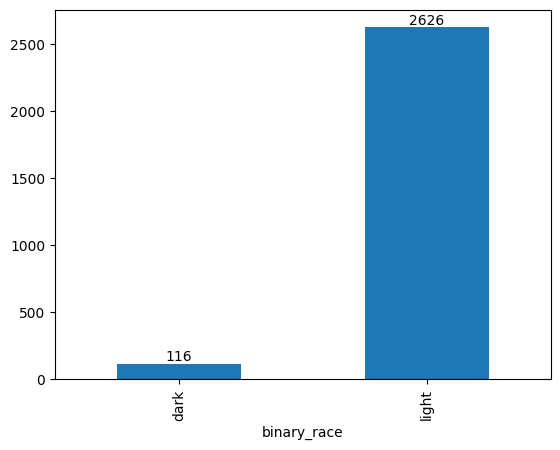

In [388]:
ax = df_label.binary_race.value_counts().sort_values().plot(kind='bar')
ax.bar_label(ax.containers[0])

In [389]:
light = df_label.loc[df_label['binary_race'] == 'light'].groupby('name').head(2)[:116].index.to_list()

In [390]:
dark = df_label.loc[df_label['binary_race'] == 'dark'].groupby('name').head(2)[:116].index.to_list()

In [391]:
light_dark_indicies = light + dark

In [392]:
final_df = df_label.iloc[light_dark_indicies].copy()

[Text(0, 0, '116'), Text(0, 0, '116')]

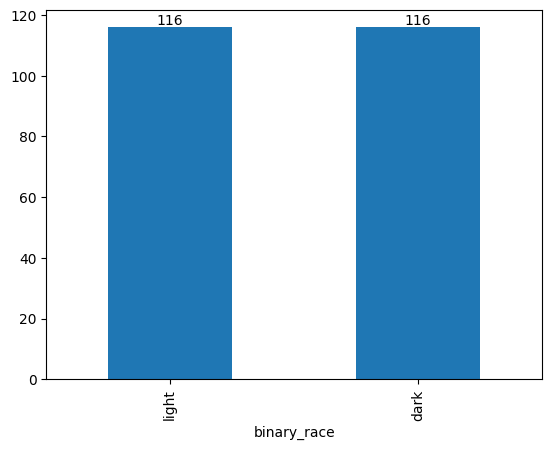

In [393]:
ax = final_df.binary_race.value_counts().sort_values().plot(kind='bar')
ax.bar_label(ax.containers[0])

In [394]:
final_df.reset_index(drop=True)

,name,Asian,White,Black,Indian,file_path,count,binary_race
0,Aaron_Peirsol,0.0,1.0,0.0,0.0,Aaron_Peirsol/Aaron_Peirsol_0001.jpg,4,light
1,Aaron_Peirsol,0.0,1.0,0.0,0.0,Aaron_Peirsol/Aaron_Peirsol_0002.jpg,4,light
2,Aaron_Sorkin,0.0,1.0,0.0,0.0,Aaron_Sorkin/Aaron_Sorkin_0001.jpg,2,light
3,Aaron_Sorkin,0.0,1.0,0.0,0.0,Aaron_Sorkin/Aaron_Sorkin_0002.jpg,2,light
4,Abdullah,0.0,1.0,0.0,0.0,Abdullah/Abdullah_0001.jpg,3,light
...,...,...,...,...,...,...,...,...
227,Venus_Williams,0.0,0.0,1.0,0.0,Venus_Williams/Venus_Williams_0003.jpg,11,dark
228,Vince_Carter,0.0,0.0,1.0,0.0,Vince_Carter/Vince_Carter_0001.jpg,2,dark
229,Vince_Carter,0.0,0.0,1.0,0.0,Vince_Carter/Vince_Carter_0002.jpg,2,dark
230,Vivica_Fox,0.0,0.0,1.0,0.0,Vivica_Fox/Vivica_Fox_0001.jpg,2,dark


In [395]:
final_df.drop(['count'], axis=1, inplace=True)

In [396]:
final_df.drop(['Asian', 'White', 'Black', 'Indian'], axis=1, inplace=True)

In [397]:
final_df

,name,file_path,binary_race
0,Aaron_Peirsol,Aaron_Peirsol/Aaron_Peirsol_0001.jpg,light
1,Aaron_Peirsol,Aaron_Peirsol/Aaron_Peirsol_0002.jpg,light
2,Aaron_Sorkin,Aaron_Sorkin/Aaron_Sorkin_0001.jpg,light
3,Aaron_Sorkin,Aaron_Sorkin/Aaron_Sorkin_0002.jpg,light
6,Abdullah,Abdullah/Abdullah_0001.jpg,light
...,...,...,...
2635,Venus_Williams,Venus_Williams/Venus_Williams_0003.jpg,dark
2646,Vince_Carter,Vince_Carter/Vince_Carter_0001.jpg,dark
2647,Vince_Carter,Vince_Carter/Vince_Carter_0002.jpg,dark
2656,Vivica_Fox,Vivica_Fox/Vivica_Fox_0001.jpg,dark


In [371]:
final_df.to_csv("compiled_lfwa+.csv")